<a href="https://colab.research.google.com/github/avigailst/pytorch-vq-vae/blob/master/Copy_of_vq_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [VQ-VAE](https://arxiv.org/abs/1711.00937) by  [Aäron van den Oord](https://twitter.com/avdnoord) et al. in PyTorch

## Introduction

Variational Auto Encoders (VAEs) can be thought of as what all but the last layer of a neural network is doing, namely feature extraction or seperating out the data. Thus given some data we can think of using a neural network for representation generation.

Recall that the goal of a generative model is to estimate the probability distribution of high dimensional data such as images, videos, audio or even text by learning the underlying structure in the data as well as the dependencies between the different elements of the data. This is very useful since we can then use this representation to generate new data with similar properties. This way we can also learn useful features from the data in an unsupervised fashion.

The VQ-VAE uses a discrete latent representation mostly because many important real-world objects are discrete. For example in images we might have categories like "Cat", "Car", etc. and it might not make sense to interpolate between these categories. Discrete representations are also easier to model since each category has a single value whereas if we had a continous latent space then we will need to normalize this density function and learn the dependencies between the different variables which could be very complex.

### Code

I have followed the code from the TensorFlow implementation by the author which you can find here [vqvae.py](https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/nets/vqvae.py) and [vqvae_example.ipynb](https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb).

Another PyTorch implementation is found at [pytorch-vqvae](https://github.com/ritheshkumar95/pytorch-vqvae).


## Basic Idea

The overall architecture is summarized in the diagram below:

![](https://github.com/avigailst/pytorch-vq-vae/blob/master/images/vq-vae.png?raw=1)

We start by defining a latent embedding space of dimension `[K, D]` where `K` are the number of embeddings and `D` is the dimensionality of each latent embeddng vector, i.e. $e_i \in \mathbb{R}^{D}$. The model is comprised of an encoder and a decoder. The encoder will map the input to a sequence of discrete latent variables, whereas the decoder will try to reconstruct the input from these latent sequences.

More preciesly, the model will take in batches of RGB images,  say $x$, each of size 32x32 for our example, and pass it through a ConvNet encoder producing some output $E(x)$, where we make sure the channels are the same as the dimensionality of the latent embedding vectors. To calculate the discrete latent variable we find the nearest embedding vector and output it's index.

The input to the decoder is the embedding vector corresponding to the index which is passed through the decoder to produce the reconstructed image.

Since the nearest neighbour lookup has no real gradient in the backward pass we simply pass the gradients from the decoder to the encoder  unaltered. The intuition is that since the output representation of the encoder and the input to the decoder share the same `D` channel dimensional space, the gradients contain useful information for how the encoder has to change its output to lower the reconstruction loss.

## Loss

The total loss is actually composed of three components

1. **reconstruction loss**: which optimizes the decoder and encoder
1. **codebook loss**: due to the fact that gradients bypass the embedding, we use a dictionary learning algorithm  which uses an $l_2$  error to move the embedding vectors $e_i$ towards the encoder output
1. **commitment loss**:  since the volume of the embedding space is dimensionless, it can grow arbirtarily if the embeddings $e_i$ do not train as fast as  the encoder parameters, and thus we add a commitment loss to make sure that the encoder commits to an embedding

In [614]:
#!pip3 install -U -r requirements.txt
# !pip install torch
# !pip install torchvision
# !pip install matplotlib
# !pip install scipy
# !pip install six
# !pip install umap-learn
# !pip install numpy==1.20


In [615]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import uuid
import os
from datetime import datetime

In [616]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import logging
run_id = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
run_dir = f'./runs/{run_id}'
os.makedirs(run_dir, exist_ok=True)

logger = logging.getLogger(f'{run_id}')
logger.setLevel(logging.DEBUG)

ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
logger.addHandler(ch)

fh = logging.FileHandler(filename=f'{run_dir}/info.log', encoding='utf-8')
fh.setLevel(logging.INFO)
logger.addHandler(fh)

fh = logging.FileHandler(filename=f'{run_dir}/debug.log', encoding='utf-8')
fh.setLevel(logging.DEBUG)
logger.addHandler(fh)

## Load Data

In [617]:
class WordEmbeddingDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [618]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import nltk

# wv = api.load('glove-wiki-gigaword-50')

In [619]:
# g_data = wv.vectors[:20000]
# pos = nltk.pos_tag(wv.index_to_key[:len(g_data)])
# g_words = np.array(wv.index_to_key[:len(g_data)])
# idx = np.array([i for i, v in enumerate(g_data) if pos[i][1] in ['NN','JJ','RB','VB'] and g_words[i] not in ['"', "n't", '_', '-', 'u.s.', '%', 'i']])
# g_data = g_data[idx]
# g_words = g_words[idx]

g_data = np.array([
    [2.,0.,0.],
    [0.,2.,0.],
    [0.,0.,2.],
    np.mean([[2.,0.,0.],[0.,2.,0.]], axis=0),
    np.mean([[2.,0.,0.],[0.,0.,2.]], axis=0),
    np.mean([[0.,2.,0.],[0.,0.,2.]], axis=0)
], dtype='float32')

logger.info(f'g_data={g_data}')
g_words = np.array([
    'zero',
    'one',
    'two',
    'three',
    'four',
    'five'
])
logger.info(f'g_words={g_words}')

g_data=[[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 2.]
 [1. 1. 0.]
 [1. 0. 1.]
 [0. 1. 1.]]
g_words=['zero' 'one' 'two' 'three' 'four' 'five']


In [620]:
data_len = len(g_data)
training_len = int(data_len * 1.0)
training_data = WordEmbeddingDataset(g_data[:training_len])
validation_data = WordEmbeddingDataset(g_data[training_len:])

In [621]:
data_variance = np.var((training_data.data + np.min(training_data.data)) / np.max(training_data.data))
data_variance

0.13888888

In [622]:
from scipy.spatial.distance import cosine

def closest_vector(v):
    i = np.argmin([cosine(v, w) for w in g_data])
    return g_data[i]

def closest_word(v):
    i = np.argmin([cosine(v, w) for w in g_data])
    return g_words[i]

def tensor_to_closest_word(t):
    return closest_word(t.detach().cpu().numpy())

def tensor_to_dict_closest_word(v):
    i = np.argmin([cosine(v.detach().cpu().numpy(), w.detach().cpu().numpy()) for w in model._vq_vae._embedding.weight])
    return tensor_to_closest_word(model._vq_vae._embedding.weight[i])

## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [623]:
#@title
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        embedding_from = 0
        embedding_to = 1./(num_embeddings * 10)
        self._embedding.weight.data.uniform_(embedding_from, embedding_to)
        # self._embedding.weight.data = torch.tensor(g_data[:3])
        self._commitment_cost = commitment_cost
        logger.info(f'embedding_from={embedding_from}\nembedding_to={embedding_to}')
        logger.info(f'self._embedding.weight.data={self._embedding.weight.data}')

    def forward(self, inputs):
        inputs = inputs.contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        repeated_input = flat_input.repeat(1, self._embedding.weight.size(0)).view(-1, self._embedding_dim)
        repeated_embedding = self._embedding.weight.repeat(flat_input.size(0), 1).view(-1, self._embedding_dim)
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        sims = cos(repeated_input, repeated_embedding).view(-1, self._embedding.weight.size(0))

        # Encoding
        encoding_indices = torch.argmax(sims, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(flat_input.shape)

        # Loss
        e_latent_loss = F.cosine_embedding_loss(quantized.detach(), flat_input, torch.ones(quantized.size(0)))
        q_latent_loss = F.cosine_embedding_loss(quantized, flat_input.detach(), torch.ones(quantized.size(0)))

        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = flat_input + (quantized - flat_input).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, quantized.contiguous(), perplexity, encodings, e_latent_loss, self._commitment_cost * q_latent_loss


We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [624]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()

        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        inputs = inputs.contiguous()

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        repeated_input = flat_input.repeat(1, self._embedding.weight.size(0)).view(-1, self._embedding_dim)
        repeated_embedding = self._embedding.weight.repeat(flat_input.size(0), 1).view(-1, self._embedding_dim)
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        sims = cos(repeated_input, repeated_embedding).view(-1, self._embedding.weight.size(0))

        # Encoding
        encoding_indices = torch.argmax(sims, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(flat_input)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.cosine_embedding_loss(quantized.detach(), flat_input, torch.ones(quantized.size(0)))
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = flat_input + (quantized - flat_input).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, quantized, perplexity, encodings

In [625]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
a = torch.tensor([[1.1,2.1,3.1,4.1], [1.1,2.1,3.1,4.1]])
b = torch.tensor([[1.,2.,3.,4.], [1.1,2.1,3.1,4.1]])
distances = cos(a, b)
distances

tensor([0.9999, 1.0000])

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [626]:
class Residual(nn.Module):
    def __init__(self, in_features, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(in_features=in_features,
                        out_features=num_residual_hiddens),
            nn.LeakyReLU(),
            nn.Linear(in_features=num_residual_hiddens,
                        out_features=num_hiddens)
           )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_features, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_features, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.leaky_relu(x)

In [627]:
class Encoder(nn.Module):
    def __init__(self, in_features, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()


        self._lin_1 = nn.Linear(in_features=in_features,
                                 out_features=num_hiddens * 10)
        self._lin_2 = nn.Linear(in_features=num_hiddens * 10,
                                 out_features=num_hiddens * 10)
        self._lin_3 = nn.Linear(in_features=num_hiddens * 10,
                                 out_features=num_hiddens * 10)
        self._lin_4 = nn.Linear(in_features=num_hiddens * 10,
                                 out_features=num_hiddens * 10)
        self._lin_5 = nn.Linear(in_features=num_hiddens * 10,
                                 out_features=num_hiddens * 10)
        self._lin_6 = nn.Linear(in_features=num_hiddens * 10,
                                 out_features=num_hiddens)
        self._residual_stack = ResidualStack(
            in_features=num_hiddens,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._lin_1(inputs)
        x = F.leaky_relu(x)

        x = self._lin_2(x)
        x = F.leaky_relu(x)

        x = self._lin_3(x)
        x = F.leaky_relu(x)

        x = self._lin_4(x)
        x = F.leaky_relu(x)

        x = self._lin_5(x)
        x = F.leaky_relu(x)

        x = self._lin_6(x)
        return self._residual_stack(x)

In [628]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim, num_words):
        super(Decoder, self).__init__()
        self._embedding_dim = embedding_dim
        self._num_words = num_words

    def forward(self, inputs):
        x = inputs.view((-1, self._num_words, self._embedding_dim))
        m = torch.mean(x,1)
        return m, x

## Train

We use the hyperparameters from the author's code:

In [629]:
batch_size = 6
num_training_updates = 100000
embedding_dim = 3
num_embeddings = 3
num_words = 2

num_residual_hiddens = embedding_dim * num_words
num_residual_layers = 2

commitment_cost = 0.25

#decay = 0.99
decay = 0

learning_rate = 1e-6

logger.info(f'batch_size={batch_size}')
logger.info(f'num_training_updates={num_training_updates}')
logger.info(f'embedding_dim={embedding_dim}')
logger.info(f'num_embeddings={num_embeddings}')
logger.info(f'num_words={num_words}')
logger.info(f'commitment_cost={commitment_cost}')
logger.info(f'decay={decay}')
logger.info(f'learning_rate={learning_rate}')


batch_size=6
num_training_updates=100000
embedding_dim=3
num_embeddings=3
num_words=2
commitment_cost=0.25
decay=0
learning_rate=1e-06


In [630]:
training_loader = DataLoader(training_data,
                             batch_size=1024,
                             shuffle=True,
                             pin_memory=True)

In [631]:
# for i in range(4):
#     print(f'{i} -------------------------')
#     x = next(iter(training_loader))
#     print(x)

In [632]:
# validation_loader = DataLoader(validation_data,
#                                batch_size=32,
#                                shuffle=True,
#                                pin_memory=True)

In [633]:
class Model(nn.Module):
    def __init__(self, in_features, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        self._encoder = Encoder(
            in_features=in_features,
            num_hiddens = num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim, num_words)

    def forward(self, x):
        z = self._encoder(x)
        loss, quantized, perplexity, _, subloss1, subloss2 = self._vq_vae(z)
        x_recon, _ = self._decoder(quantized)

        return loss, x_recon, perplexity, subloss1, subloss2

In [634]:
model = Model(embedding_dim, embedding_dim * num_words, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay).to(device)

embedding_from=0
embedding_to=0.03333333333333333
self._embedding.weight.data=tensor([[0.0229, 0.0180, 0.0295],
        [0.0111, 0.0074, 0.0178],
        [0.0303, 0.0238, 0.0160]])


In [635]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [636]:
def replace_by_closest_words(embedding):
    embedding.weight.data = torch.Tensor(
        [np.array(closest_vector(v.cpu().detach().numpy()))
         for v in embedding.weight.data]
    )

In [637]:
from time import gmtime, strftime

print (strftime("%H:%M:%S", gmtime()))

model.train()
train_res_recon_error = []
train_res_perplexity = []
train_vq_loss = []
train_vq_subloss1 = []
train_vq_subloss2 = []

init_loss_threshold = loss_threshold = 0.04
min_loss = last_loss = 1.0

for i in xrange(num_training_updates):
    data = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity, vq_subloss1, vq_subloss2 = model(data)
    #recon_error = F.mse_loss(data_recon, data) / data_variance
    recon_error = F.cosine_embedding_loss(data_recon, data, torch.ones(data_recon.size(0)))
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())
    train_vq_loss.append(vq_loss.item())
    train_vq_subloss1.append(vq_subloss1.item())
    train_vq_subloss2.append(vq_subloss2.item())

    num_iter_to_change = 50

    # if (i+1) % num_iter_to_change == 0:
    #     replace_by_closest_words(model._vq_vae._embedding)

    if  (i+1) % num_iter_to_change == 0:
        logger.debug(strftime("%H:%M:%S", gmtime()))
        logger.debug('%')
        logger.debug('%d iterations' % (i+1))
        logger.debug('vq_loss: %.3f' % np.mean(train_vq_loss[-100:]))
        logger.debug('vq_subloss1: %.3f' % np.mean(train_vq_subloss1[-100:]))
        logger.debug('vq_subloss2: %.3f' % np.mean(train_vq_subloss2[-100:]))
        logger.debug('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        logger.debug('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        logger.debug('')
        last_loss = np.mean(train_res_recon_error[-100:])
        if last_loss < min_loss:
            min_loss = last_loss
        if min_loss < loss_threshold:
            PATH = f'{run_dir}/model-loss-{round(min_loss, 3)}.pt'
            torch.save(model, PATH)
            loss_threshold = round(last_loss, 0)

13:25:10


13:25:10
%
50 iterations
vq_loss: 0.377
vq_subloss1: 0.302
vq_subloss2: 0.075
recon_error: 0.309
perplexity: 2.505

13:25:10
%
100 iterations
vq_loss: 0.376
vq_subloss1: 0.301
vq_subloss2: 0.075
recon_error: 0.308
perplexity: 2.508

13:25:10
%
150 iterations
vq_loss: 0.373
vq_subloss1: 0.299
vq_subloss2: 0.075
recon_error: 0.307
perplexity: 2.630

13:25:11
%
200 iterations
vq_loss: 0.370
vq_subloss1: 0.296
vq_subloss2: 0.074
recon_error: 0.306
perplexity: 2.749

13:25:11
%
250 iterations
vq_loss: 0.367
vq_subloss1: 0.294
vq_subloss2: 0.073
recon_error: 0.306
perplexity: 2.751

13:25:11
%
300 iterations
vq_loss: 0.364
vq_subloss1: 0.291
vq_subloss2: 0.073
recon_error: 0.306
perplexity: 2.617

13:25:11
%
350 iterations
vq_loss: 0.361
vq_subloss1: 0.289
vq_subloss2: 0.072
recon_error: 0.307
perplexity: 2.240

13:25:11
%
400 iterations
vq_loss: 0.359
vq_subloss1: 0.287
vq_subloss2: 0.072
recon_error: 0.307
perplexity: 2.000

13:25:11
%
450 iterations
vq_loss: 0.356
vq_subloss1: 0.285
vq_su

In [638]:
model = torch.load(PATH)
## Plot Loss

In [639]:

train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)
train_vq_loss_smooth = savgol_filter(train_vq_loss, 201, 7)
train_vq_subloss1_smooth = savgol_filter(train_vq_subloss1, 201, 7)
train_vq_subloss2_smooth = savgol_filter(train_vq_subloss2, 201, 7)

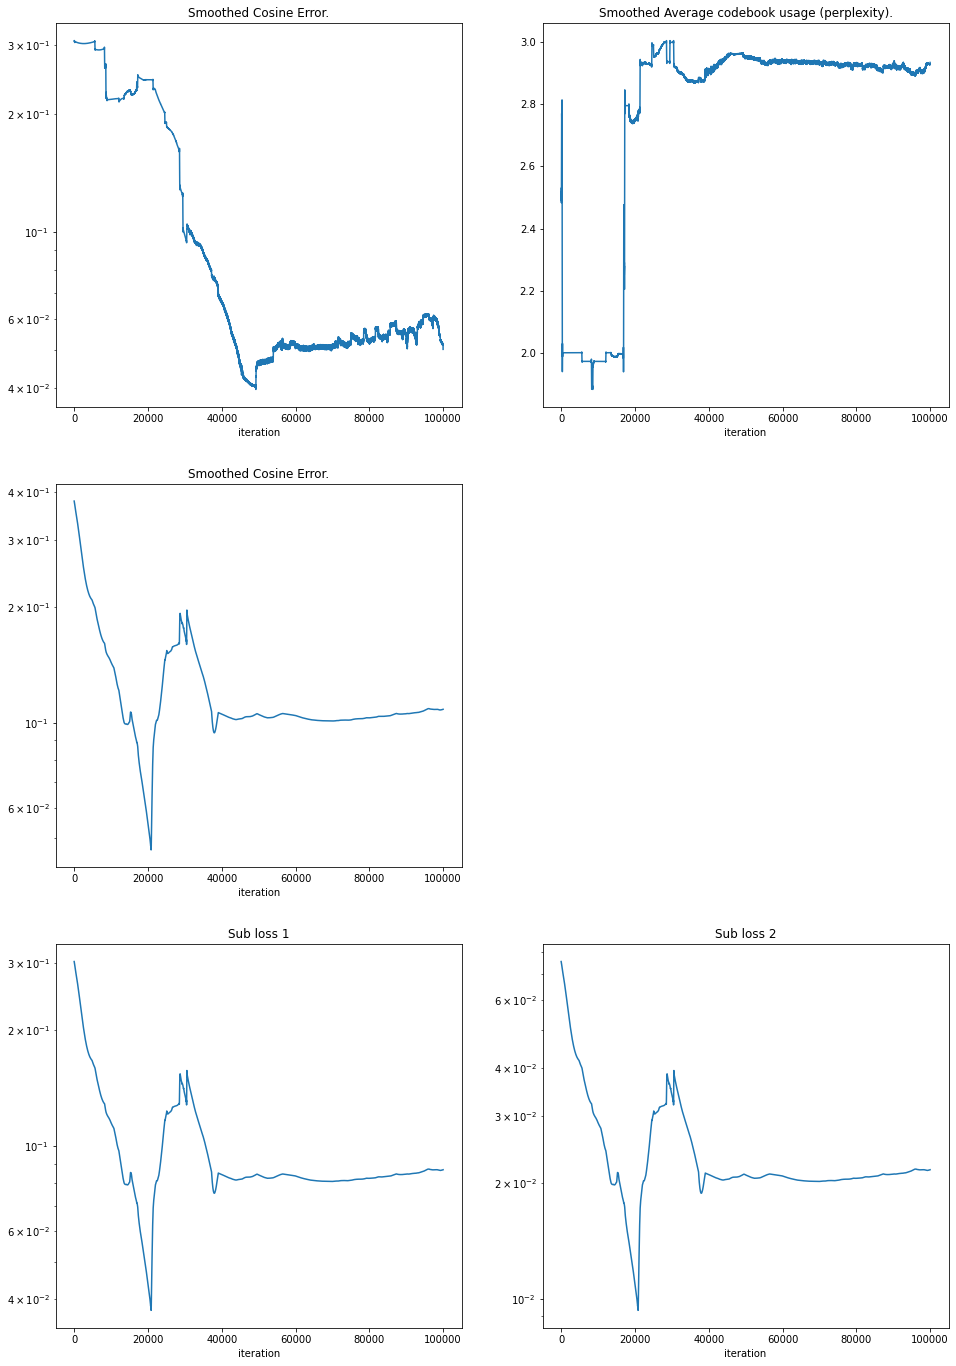

In [640]:
f = plt.figure(figsize=(16,24))
ax = f.add_subplot(3,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed Cosine Error.')
ax.set_xlabel('iteration')

ax = f.add_subplot(3,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

ax = f.add_subplot(3,2,3)
ax.plot(train_vq_loss_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed Cosine Error.')
ax.set_xlabel('iteration')

ax = f.add_subplot(3,2,5)
ax.plot(train_vq_subloss1_smooth)
ax.set_yscale('log')
ax.set_title('Sub loss 1')
ax.set_xlabel('iteration')

ax = f.add_subplot(3,2,6)
ax.plot(train_vq_subloss2_smooth)
ax.set_yscale('log')
ax.set_title('Sub loss 2')
ax.set_xlabel('iteration')


plt.savefig(f'{run_dir}/loss.png')

## View Reconstructions

In [641]:
model.eval()

Model(
  (_encoder): Encoder(
    (_lin_1): Linear(in_features=3, out_features=60, bias=True)
    (_lin_2): Linear(in_features=60, out_features=60, bias=True)
    (_lin_3): Linear(in_features=60, out_features=60, bias=True)
    (_lin_4): Linear(in_features=60, out_features=60, bias=True)
    (_lin_5): Linear(in_features=60, out_features=60, bias=True)
    (_lin_6): Linear(in_features=60, out_features=6, bias=True)
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0): Residual(
          (_block): Sequential(
            (0): LeakyReLU(negative_slope=0.01)
            (1): Linear(in_features=6, out_features=6, bias=True)
            (2): LeakyReLU(negative_slope=0.01)
            (3): Linear(in_features=6, out_features=6, bias=True)
          )
        )
        (1): Residual(
          (_block): Sequential(
            (0): LeakyReLU(negative_slope=0.01)
            (1): Linear(in_features=6, out_features=6, bias=True)
            (2): LeakyReLU(negative_slope

In [642]:
# valid_originals = next(iter(validation_loader))
# valid_originals = valid_originals.to(device)
#
# vq_output_eval = model._encoder(valid_originals)
# _, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
# valid_reconstructions, defs = model._decoder(valid_quantize)
#
# for i in range(len(valid_originals)):
#     orig_word = tensor_to_closest_word(valid_originals[i])
#     recon_word = tensor_to_closest_word(valid_reconstructions[i])
#     def_text = ' '.join([tensor_to_closest_word(v) for v in defs[i]])
#     print(f'{orig_word} to {recon_word}: {def_text}')

In [643]:
train_originals = next(iter(training_loader))
train_originals = train_originals.to(device)

vq_output_eval = model._encoder(train_originals)
_, train_quantize, _, _, _, _ = model._vq_vae(vq_output_eval)
train_reconstructions, defs = model._decoder(train_quantize)

for i in range(len(train_originals)):
    orig_word = tensor_to_closest_word(train_originals[i])
    recon_word = tensor_to_closest_word(train_reconstructions[i])
    def_text = ' '.join([tensor_to_dict_closest_word(v) for v in defs[i]])
    logger.info(f'{orig_word} to {recon_word}: {def_text}')

four to four: four three
three to four: four three
five to four: four three
two to four: four three
one to four: four three
zero to four: four three


## View Embedding

In [644]:
# proj = umap.UMAP(n_neighbors=3,
#                  min_dist=0.1,
#                  metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())
#

In [645]:
# plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

In [646]:
for i in range(num_embeddings):
    logger.info(f'{i}:\t{tensor_to_closest_word(model._vq_vae._embedding.weight.data[i])} {model._vq_vae._embedding.weight.data[i].tolist()}')

0:	four [0.022893982008099556, 0.018075715750455856, 0.029567403718829155]
1:	four [0.011085531674325466, 0.007465529255568981, 0.01784626394510269]
2:	three [0.030227921903133392, 0.023876411840319633, 0.015964923426508904]


In [647]:
logging.shutdown()